First let's load the Jar. This requires `mill q.assembly` to be run beforehand.

In [1]:
interp.load.cp(os.pwd/".."/"out"/"q"/"assembly.dest"/"out.jar")

We will load some boilerplate code for graphing as well.

In [2]:
import $file.makeplot

import $file.$

Now, all the imports...

In [3]:
import riscq._
import riscq.tester._
import spinal.core.sim._
import spinal.core._
import spinal.lib.bus.tilelink.sim._
import spinal.lib.bus.tilelink._
import spinal.lib.bus.amba4.axi.sim.Axi4Master
import riscq.tester.RvAssembler
import riscq.tester.QubicAssembler
import riscq.tester.ByteHelper
import scala.collection.mutable.ArrayBuffer
import spinal.lib._
import riscq.soc.MemoryMapSoc
import riscq.tester.RvAssembler
import riscq.tester.mmsoc.MMSocDriver
import spinal.lib.misc.Elf
import java.io.File
import riscq.soc.MemoryMapSoc
import riscq.soc.MemoryMapPlugins
import net.fornwall.jelf.ElfSectionHeader
import riscq.tester.mmsoc._

import riscq._
import riscq.tester._
import spinal.core.sim._
import spinal.core._
import spinal.lib.bus.tilelink.sim._
import spinal.lib.bus.tilelink._
import spinal.lib.bus.amba4.axi.sim.Axi4Master
import riscq.tester.RvAssembler
import riscq.tester.QubicAssembler
import riscq.tester.ByteHelper
import scala.collection.mutable.ArrayBuffer
import spinal.lib._
import riscq.soc.MemoryMapSoc
import riscq.tester.RvAssembler
import riscq.tester.mmsoc.MMSocDriver
import spinal.lib.misc.Elf
import java.io.File
import riscq.soc.MemoryMapSoc
import riscq.soc.MemoryMapPlugins
import net.fornwall.jelf.ElfSectionHeader
import riscq.tester.mmsoc._

Some Gaussian nonsense...

In [4]:
def gaussian(width: Int, sigmas: Double = 3.0): Seq[Double] = {
  val sigma = width.toDouble / (2.0 * sigmas)
  val vals = (0 until width).map { i =>
    val x = i - width.toDouble / 2.0
    scala.math.exp(-(x * x) / (2 * sigma * sigma))
  }
  return vals
}

defined function gaussian

Now, time to collect some outputs.

In [6]:
val dac_output = ArrayBuffer[Double]()
val carrier_output = ArrayBuffer[Double]()
val simConfig = SimConfig.addSimulatorFlag("-Wno-MULTIDRIVEN")
  simConfig
    .compile {
      val dut = MemoryMapSoc(
        qubitNum = 4,
        withVivado = false,
        withCocotb = false,
        withWhitebox = true,
        withTest = true
      ) 
      dut.pgs.map { _.io.simPublic() }
      dut.cgs.map { _.io.simPublic() }
      dut
    }
    .doSim { dut =>
      val driver = new Driver(dut)
      import driver._

      init()


      val batchSize = 16
      val dataWidth = 16
      for (i <- 0 until 100) {
        val dt = if (i == 0) BigInt(10) else BigInt(1000)
        val batch = List.fill(batchSize)(dt)
        val batchData = riscq.pulse.PGTestPulse.concat(batch, dataWidth)
        val dataStr = batch.map { x => ByteHelper.intToBinStr(x, dataWidth) }.reduce { _ ++ _ }
        tlDriver.putFullData(0, dut.pmAxiOffset + (1 << 21) + i * batchSize * dataWidth / 8, ByteHelper.fromBinStr(dataStr).reverse)
        // axi4Driver.write(dut.pmAxiOffset + i * batchSize * dataWidth / 8, ByteHelper.fromBinStr(dataStr).reverse.toList)
      }
      cd100m.waitRisingEdge()


      val elfFile = new File("../compiler-scripts/pg_test.elf")
      val elf = new Elf(elfFile, addressWidth = 32)
      elf.load(dut.mem.mem, -0x80000000)

      val startTime = 50

      dut.riscq_rst #= true
      tick(10)
      dut.riscq_rst #= false

      val monitor = new Monitor(dut.dBus.bus, cd)
      val pcReset = 0x80000000l
      monitor.add(new MonitorSubscriber {
        override def onA(a: TransactionA) = {println(s"${simTime()}"); println(a)}
        override def onD(d: TransactionD) = {println(s"!!!!!!!${simTime()}");println(d)}
      })

      tick(30)
      for(t <- 100 until 500 by 100) {
        driver.waitUntil(t - 1)
        for(i <- 0 until 10) {
          logTime()
          logDac(1)
          logCarrier(1)
          tick()
        }
      }
        
      // waitUntil(99)
      for (i <- 0 until 10) {
        // println(s"${dut.mem.mem.getBigInt(0).toString(16)}")
        // println(s"${dut.mem.mem.getBigInt(0x1d).toString(16)}")
        // println(s"${dut.mmFiber.logic.cgParams(0).cgIo.freq.toDouble}")
        // println(s"bypass: ${wb.hazard.bypass_1.map{case (id, data) => (id, data.toBoolean)}}")
        logTime()
        // logBranch()
        // logHazard()
        // logPcs()
        // logSrc()
        // logExInsts()
        logDac(2)
        println("")
        val dac = dut.pgs(0).io.data
        val pulse = dac.payload.map { _.r.toDouble * (1 << 14) }.toList
        dac_output ++= pulse
        val carrier = dut.cgs(0).io.carrier
        val data = carrier.payload.map { _.r.toDouble * (1 << 14) }.toList
        carrier_output ++= data
        tick()
      }
    }


[Runtime] SpinalHDL dev    git head : bbe3c9911a233a5aa9672c70d237336385ab7dcc
[Runtime] JVM max memory : 3910.0MiB
[Runtime] Current date : 2025.04.05 12:19:16
[Progress] at 46.959 : Elaborate components
debug jumps: ArrayBuffer(toplevel/riscqArea_riscq/null)
########################1
debug hazard ctrlrange: Range 0 to 0
debug hazard ds: 0
!!!!!!!!!!!!!###########Range 0 until 2
!!!!!!!!!!!!!###########Range 0 until 2
[Progress] at 48.172 : Checks and transforms
[Progress] at 50.548 : Generate Verilog to ./simWorkspace/tmp/job_2
[Warning] toplevel/riscqArea_riscq/integer_RegFilePlugin_logic_regfile_fpga/asMem_ram : Mem[32*32 bits].readAsync can only be write first into Verilog
[Warning] toplevel/riscqArea_riscq/integer_RegFilePlugin_logic_regfile_fpga/asMem_ram : Mem[32*32 bits].readAsync can only be write first into Verilog
[Warning] toplevel/cd100mLogic_pulseMemWa_logic_bridge/upsize_d_ctx/contexts : Mem[16*3 bits].readAsync can only be write first into Verilog
[Warning] toplevel/ri

185770
GET param=0 source=0 addr=0x4008 bytes=4

time: 199
pulse ev: v: false, amp: 9311, start: 1346
pulse: List(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
carrier ev: v: false, freq: 0.759979248046875, phase: 0.0386962890625
List(-15285.0, -15898.0, -16266.0, -16384.0, -16249.0, -15863.0, -15232.0, -14368.0, -13281.0, -11989.0, -7228.0, -8995.0, -10622.0, -12086.0, -13364.0, -14435.0)
time: 200
pulse ev: v: false, amp: 9311, start: 1346
pulse: List(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
carrier ev: v: false, freq: 0.759979248046875, phase: 0.0386962890625
List(-15898.0, -16266.0, -16383.0, -16248.0, -15862.0, -15232.0, -14367.0, -13281.0, -11989.0, -10513.0, -8994.0, -10622.0, -12086.0, -13363.0, -14435.0, -15284.0)
time: 201
pulse ev: v: false, amp: 9311, start: 1346
pulse: List(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
carrier ev: v: false, freq: 0.759979248046875, ph

time: 307
pulse ev: v: false, amp: 9311, start: 1346
pulse: List(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
carrier ev: v: false, freq: 0.759979248046875, phase: 0.0386962890625
List(-14498.0, -13441.0, -12175.0, -10723.0, -9105.0, -7347.0, -5476.0, -3521.0, -1510.0, 523.0, -15829.0, -16231.0, -16382.0, -16280.0, -15929.0, -15331.0)
time: 308
pulse ev: v: false, amp: 9311, start: 1346
pulse: List(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
carrier ev: v: false, freq: 0.759979248046875, phase: 0.0386962890625
List(-13441.0, -12176.0, -10723.0, -9105.0, -7347.0, -5476.0, -3520.0, -1510.0, 523.0, 2549.0, -16231.0, -16383.0, -16281.0, -15929.0, -15332.0, -14498.0)
!!!!!!!187340
ACCESS_ACK_DATA param=0 source=0 addr=0x4008 bytes=4
- 00 00 00 00

!!!!!!!187350
ACCESS_ACK_DATA param=0 source=1 addr=0x4008 bytes=4
- 00 00 00 00

187450
PUT_FULL_DATA param=0 source=0 addr=0x20200 bytes=4
- cc 0c 00 00

187460
PUT_FULL_DATA

dac_output: ArrayBuffer[Double] = ArrayBuffer(
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
...
carrier_output: ArrayBuffer[Double] = ArrayBuffer(
  -15219.0,
  -15860.0,
  -16251.0,
  -16384.0,
  -16258.0,
  -15875.0,
  -15242.0,
  -14368.0,
  -13267.0,
  -5014.0,
  -6931.0,
  -8739.0,
  -10408.0,
  -11914.0,
  -13230.0,
  -14338.0,
  -15860.0,
  -16251.0,
  -16384.0,
  -16259.0,
  -15876.0,
  -15242.0,
  -14368.0,
  -13267.0,
  -11957.0,
  -6931.0,
  -8738.0,
  -10408.0,
  -11913.0,
  -13230.0,
  -14338.0,
  -15219.0,
  -16250.0,
  -16384.0,
  -16259.0,
  -15876.0,
  -15243.0,
  -14368.0,
...
simConfig: SpinalSimConfig = SpinalSimConfig(
  "./simWorkspace",
  null,
  0,
  SpinalConfig(
    null,
    Set(),
    Set(),
    false,
    ClockDomainConfig(RISING, ASYNC, HI

Plotting...

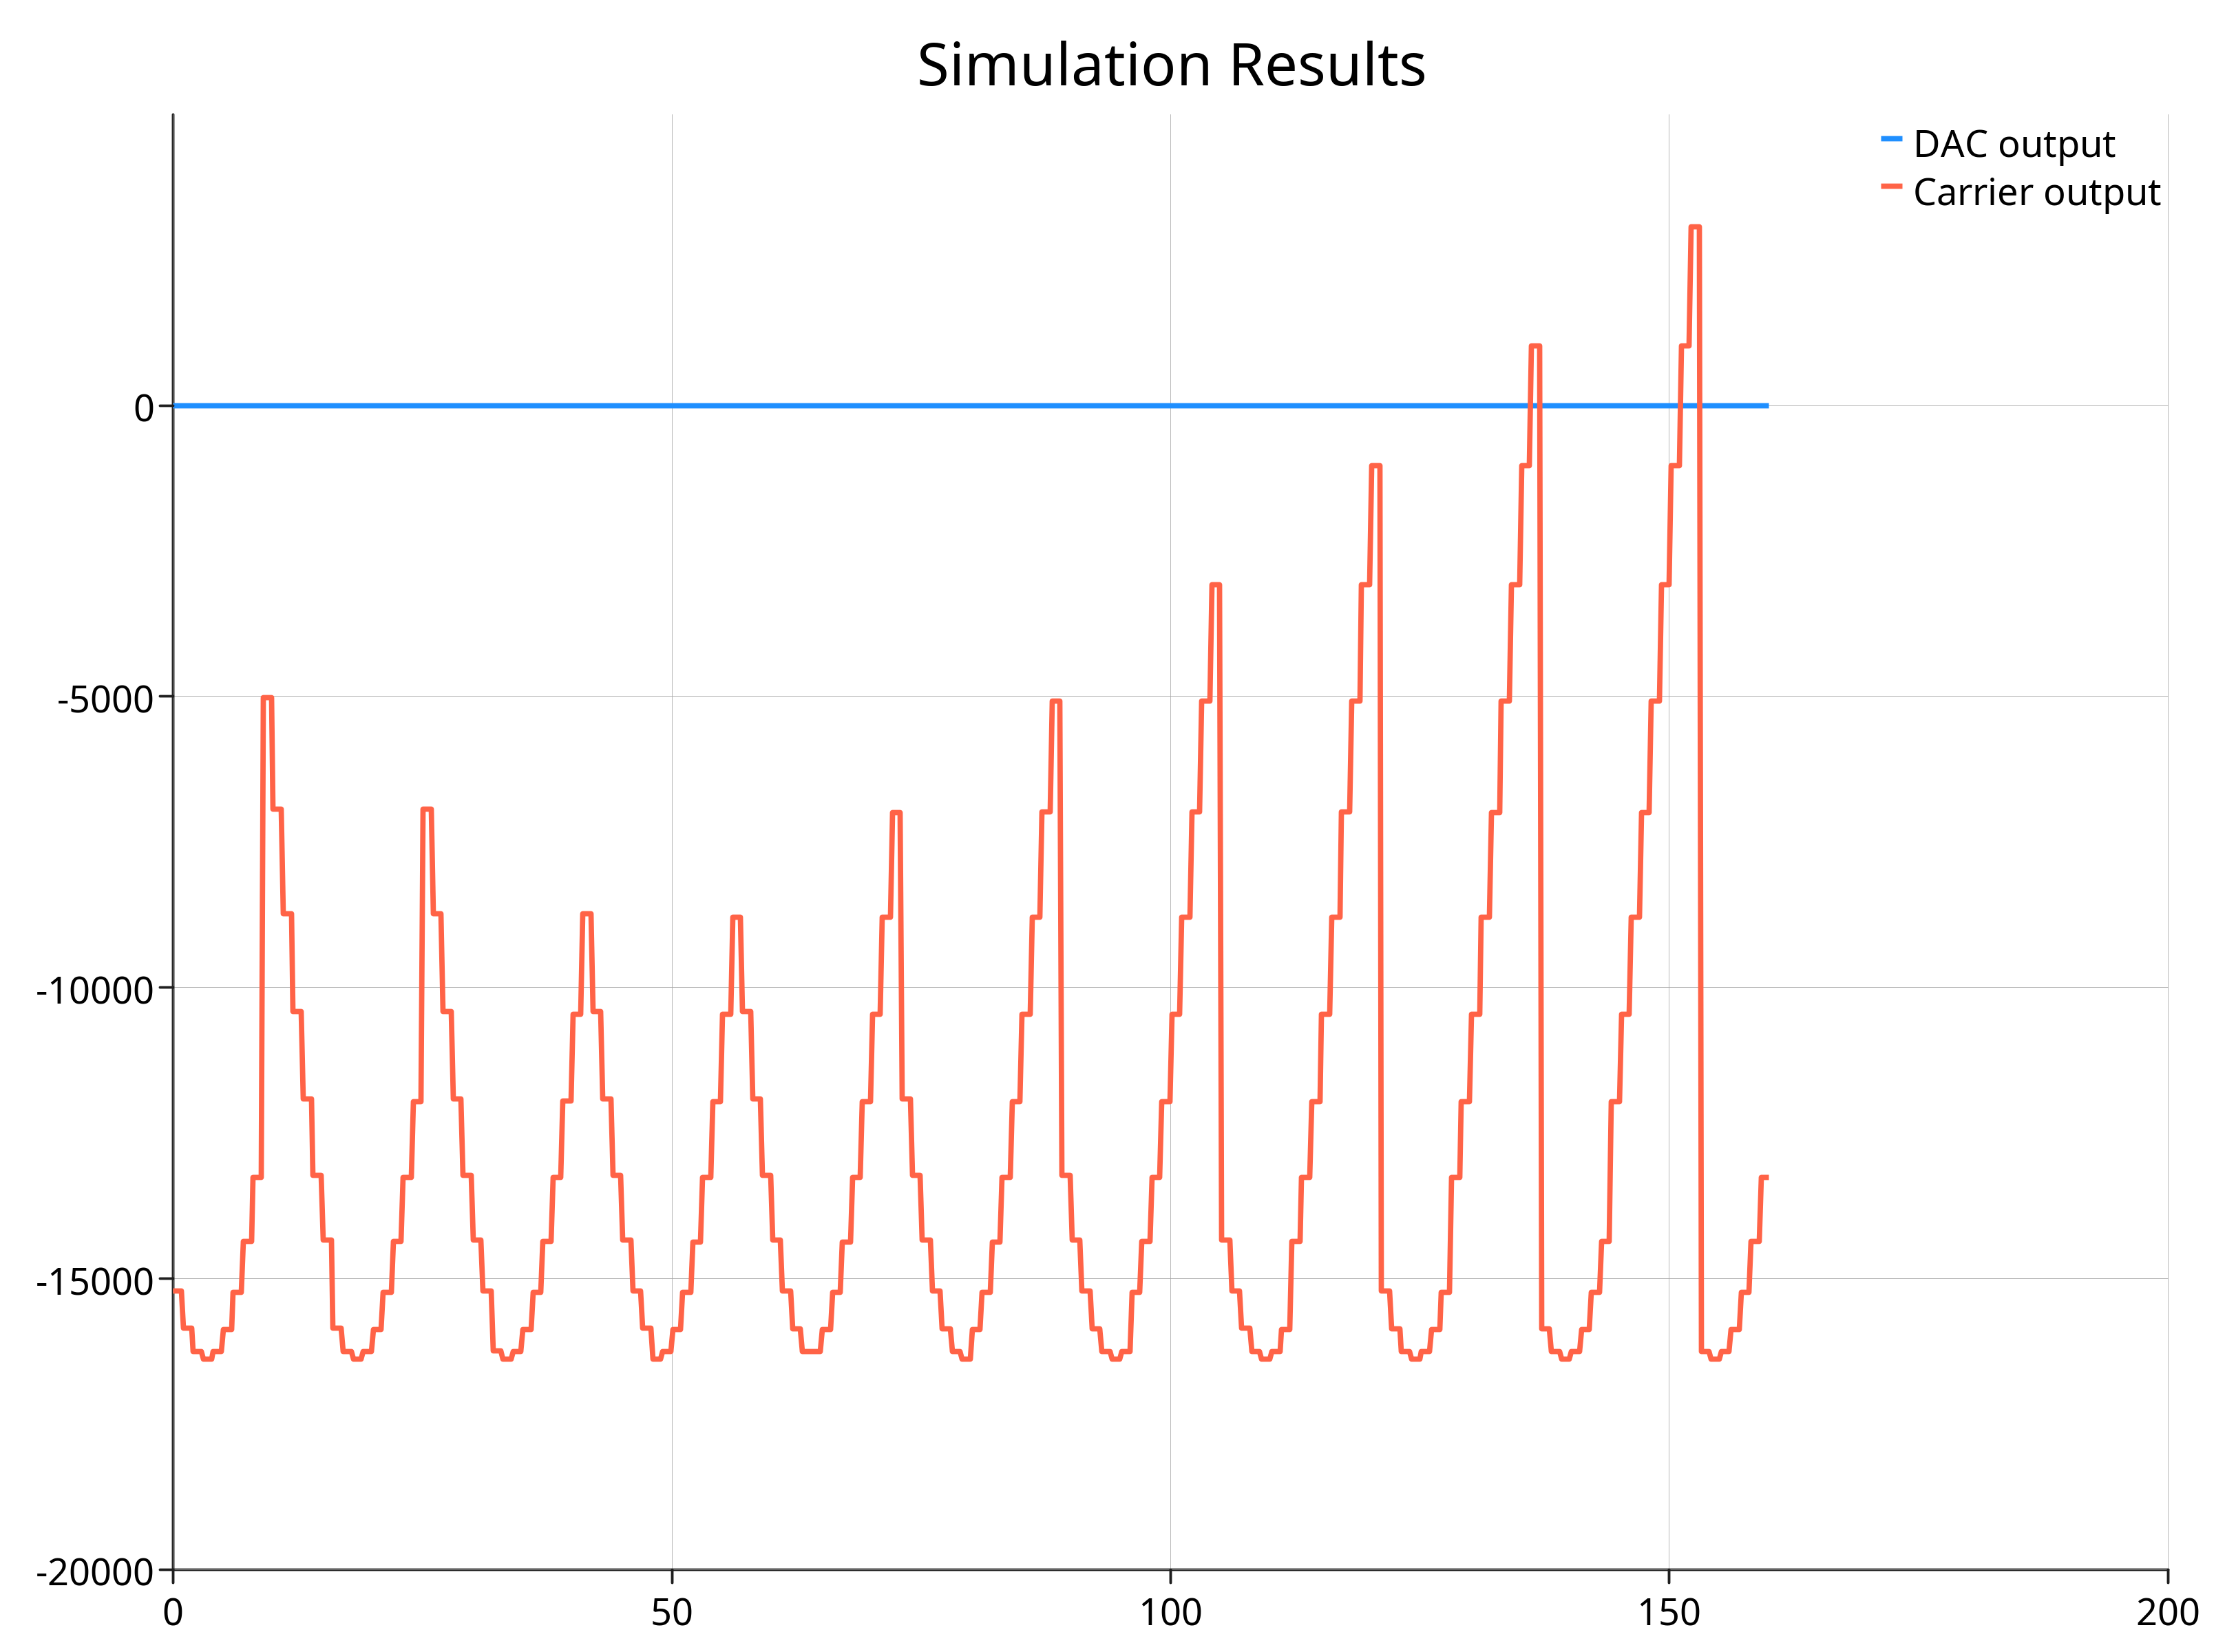

pngBytes: Array[Byte] = Array(
  -119,
  80,
  78,
  71,
  13,
  10,
  26,
  10,
  0,
  0,
  0,
  13,
  73,
  72,
  68,
  82,
  0,
  0,
  12,
  -80,
  0,
  0,
  9,
  96,
  8,
  6,
  0,
  0,
  0,
  34,
  11,
  47,
  101,
  0,
  0,
  -128,
  0,
  73,
...

In [7]:
val pngBytes = makeplot.make_plot(List(makeplot.LabeledData("DAC output", dac_output), makeplot.LabeledData("Carrier output", carrier_output)))
Image(pngBytes)